import all required library

In [1]:
import pandas as pd
import re
import string
from tqdm.notebook import tqdm
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from gensim.summarization import summarize, keywords
from collections import Counter
from nltk.tokenize import word_tokenize

In [2]:
import pickle
model_mnb = 'model_sentiment_byu_tanpa_stopword.data'
# buka file namasiswa.data
f = open(model_mnb, 'rb')
# load data dari file tersebut
model_mnb = pickle.load(f)
f.close()
print(model_mnb)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('classifier', MultinomialNB())])


In [3]:
import pandas as pd
data = pd.read_csv("tweet_implementasi.csv")

data.sort_values("created_at", ascending = True)

data.head()

created_at               source  \
0  2020-12-27 06:49:32+00:00  Twitter for Android   
1  2020-12-27 06:49:07+00:00  Twitter for Android   
2  2020-12-27 06:48:44+00:00  Twitter for Android   
3  2020-12-27 06:41:22+00:00  Twitter for Android   
4  2020-12-27 06:39:37+00:00  Twitter for Android   

                                                text      label  
0  By.U please kerja sama cuma bbrp jam doang ple...  unlabeled  
1  Happy 1st Anniversary @byu_id \nSering sering ...  unlabeled  
2                            beli kuota byu kapan ya  unlabeled  
3  Techi waktu itu msh 17 tahun loh. Dan dia udh ...  unlabeled  
4        byu anjggggg ini lagi t7s dodol malah lemot  unlabeled

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  1075 non-null   object
 1   source      1075 non-null   object
 2   text        1075 non-null   object
 3   label       1075 non-null   object
dtypes: object(4)
memory usage: 33.7+ KB


In [5]:
output_text = []
def clean_text(list_of_text):
  for text in tqdm(list_of_text):    
    text = text.translate(str.maketrans("","", string.punctuation)).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+ ', '', text)
    text = re.sub(r'#\w+ ', '', text)
    text = re.sub(r"pic\S+", "", text)
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    output_text.append(text)
  return output_text

In [6]:
data['text'] = clean_text(list(data['text']))

In [7]:
slanglist = pd.read_csv("slanglist.csv" ,encoding = "ISO-8859-1")

In [8]:
def slang(text):
    text = str(text).lower()
    text = nltk.word_tokenize(text)
    ul = 0
    for a in slanglist['slang']:
        w = 0
        for kt in text:
            if kt ==a:
                text[w] = slanglist['formal'][ul]
            w = w+1
        ul=ul+1
    kal = ""
    for kl in text:
        kal = kal + " " + kl
    text = kal
    return kal

In [9]:
data['text'] = data['text'].apply(lambda text : slang(text))

#Create STOP Word Remover
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
output_text = []
def stop(list_of_text):
  for text in tqdm(list_of_text): 
    text = stopword.remove(text)
    output_text.append(text)
  return output_text

data['text'] = stop(list(data['text']))
#data_noslang.to_csv("data_stop.csv",index=False)

In [10]:
stop_factory = StopWordRemoverFactory().get_stop_words()
more_stopword = ['enggak','banget','sih','nih','yang','deh','sangat','ini','kalau','buat','kira','s3','oy']
 
# Merge stopword
stopword = stop_factory + more_stopword
 
dictionary = ArrayDictionary(stopword)
r_sw = StopWordRemover(dictionary)

In [11]:
data['text'] = data['text'].apply(lambda x : r_sw.remove(x))

In [12]:
# create stemmer
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()
output_text = []
def stem_data(list_of_text):
  for text in tqdm(list_of_text): 
    text = stemmer.stem(text)
    output_text.append(text)
  return output_text

In [13]:
data['text'] = stem_data(list(data['text']))

In [14]:
y = pd.DataFrame(columns=['source','text','label'])

In [15]:
hasil_tes = model_mnb.predict(data.text)

In [16]:
y['label'] = hasil_tes

In [17]:
y['text'] = data['text']

In [18]:
y['source'] = data['source']

In [19]:
y.head(50)

source                                               text  \
0   Twitter for Android             byu kerja sama cuma beberapa jam doang   
1   Twitter for Android  happy 1st anniversary byu sering sering trakti...   
2   Twitter for Android                               beli kuota byu kapan   
3   Twitter for Android  techi waktu masih 17 tahun loh dia pikir mungk...   
4   Twitter for Android            byu anjggggg lagi t7s dodol malah lelet   
5   Twitter for Android  tonton beyond klive ada darah tinggi gara gara...   
6   Twitter for Android  indosat sinyal hari jelek bulan depan aku engg...   
7   Twitter for Android           coba pakai byu by telkomsel moga cucookk   
8   Twitter for Android  beli kartu by telkomsel lewat link biar pakai ...   
9   Twitter for Android  tonton beyond live ada kesal anjing byu lelet ...   
10  Twitter for Android                                    minta marah byu   
11  Twitter for Android  byu hari lancar buat beberapa jam aku mau liha...   
12  Twitter for Android                         gila byu sinyal jelek haha   
13  Twitter for Android  kuota mau habis tiba notifikasi begini terimak...   
14      Twitter Web App                       by tolong ayo jangan lemotty   
15  Twitter for Android                               wah 1 tahun kita byu   
16  Twitter for Android                                     byu anak siapa   
17  Twitter for Android  baik byu asih kuota gratis monthiversary huhuh...   
18  Twitter for Android                                   sinyal byu resah   
19   Twitter for iPhone  beberapa relasi amp kolega jakarta pakai byu k...   
20  Twitter for Android                                          byu lelet   
21  Twitter for Android  walaupun aku stres lama kamar cenderung selalu...   
22   Twitter for iPhone  aku mau beli kuota di sini by sinyal jelek yow...   
23   Twitter for iPhone  gon nya sayang this but im disgusting by prete...   
24     Twitter for iPad                       byu mati lampu sinyal hilang   
25  Twitter for Android  ah kesal akhir akhir byu suka jelek jaring jad...   
26   Twitter for iPhone  mana sembah tahan puriz mana muncul laaku mala...   
27  Twitter for Android                               asli by jelek sinyal   
28  Twitter for Android                         byu sih lelet naudzubillah   
29  Twitter for Android  halo temanteman bantu teman lulus yuk kriteria...   
30  Twitter for Android                              byu sinyal nya sampah   
31   Twitter for iPhone                                lelet sih byu allah   
32  Twitter for Android                       mau raya anniversary nih byu   
33  Twitter for Android  kemarin kan aku beli kartu byu terus pilih 1mb...   
34   Twitter for iPhone   aku pakai by tapi paket miskin alias 5gb 15 ribu   
35  Twitter for Android  guys mau tanya yang pakai kartu byu sampai rum...   
36  Twitter for Android                  4g 3g byu telkomsel aduhai sekali   
37  Twitter for Android  sini adda pakai provider byu minta ulas dong b...   
38  Twitter for Android  admin byu paket 25mbps unlimited 140 ribu diba...   
39   Twitter for iPhone  halo admin byu pakai kuota 10gb per hari kok b...   
40   Twitter for iPhone  baru ecek sisa kuota telkomsel aku nyata sisa ...   
41  Twitter for Android             byu kemarin isi paket gagal melulu deh   
42   Twitter for iPhone           aku mau keluh soal kartu byu tapi sering   
43  Twitter for Android  yuhu asa pakai byu 9 bulan kado seperti kayak ...   
44  Twitter for Android           dadah byu jaring leluhur jauh lebih baik   
45  Twitter for Android  kuota byu habis mau beli kok paket banyak semu...   
46  Twitter for Android  butuh sim card baru terus ingat by akhir beli ...   
47  Twitter for Android                                           laku byu   
48   Twitter for iPhone  byu hari jalan dengar youtube cuma pakai 3gb c...   
49  Twitter for Android  byu makin malam bukan makin bagus malah makin ...   

      label  
0   negatif  
1   positi

In [20]:
#Convert hasil ke list (hasil tadinya dalam bentuk ndarray)

l_hasil = list(hasil_tes)
print("Prediksi tweet positif: " + str(l_hasil.count("positif")))
print("Prediksi tweet negatif: " + str(l_hasil.count("negatif")))
#print("Prediksi tweet irelevant: " + str(l_hasil.count("irrelevant")))
#print("Prediksi tweet netral: " + str(l_hasil.count("netral")))

num_positif = 100*(l_hasil.count("positif")/len(l_hasil))
num_negatif = 100*(l_hasil.count("negatif")/len(l_hasil))

print("Persentase tweet positif = {:.2f} %".format(num_positif))
print("Persentase tweet negatif = {:.2f} %".format(num_negatif))

Prediksi tweet positif: 657
Prediksi tweet negatif: 418
Persentase tweet positif = 61.12 %
Persentase tweet negatif = 38.88 %


In [22]:
label_positif = y[y['label'] == "positif"]
label_positif.head(20)

source                                               text  \
1   Twitter for Android  happy 1st anniversary byu sering sering trakti...   
2   Twitter for Android                               beli kuota byu kapan   
3   Twitter for Android  techi waktu masih 17 tahun loh dia pikir mungk...   
7   Twitter for Android           coba pakai byu by telkomsel moga cucookk   
8   Twitter for Android  beli kartu by telkomsel lewat link biar pakai ...   
13  Twitter for Android  kuota mau habis tiba notifikasi begini terimak...   
15  Twitter for Android                               wah 1 tahun kita byu   
16  Twitter for Android                                     byu anak siapa   
17  Twitter for Android  baik byu asih kuota gratis monthiversary huhuh...   
19   Twitter for iPhone  beberapa relasi amp kolega jakarta pakai byu k...   
29  Twitter for Android  halo temanteman bantu teman lulus yuk kriteria...   
32  Twitter for Android                       mau raya anniversary nih byu   
33  Twitter for Android  kemarin kan aku beli kartu byu terus pilih 1mb...   
34   Twitter for iPhone   aku pakai by tapi paket miskin alias 5gb 15 ribu   
35  Twitter for Android  guys mau tanya yang pakai kartu byu sampai rum...   
37  Twitter for Android  sini adda pakai provider byu minta ulas dong b...   
38  Twitter for Android  admin byu paket 25mbps unlimited 140 ribu diba...   
40   Twitter for iPhone  baru ecek sisa kuota telkomsel aku nyata sisa ...   
42   Twitter for iPhone           aku mau keluh soal kartu byu tapi sering   
43  Twitter for Android  yuhu asa pakai byu 9 bulan kado seperti kayak ...   

      label  
1   positif  
2   positif  
3   positif  
7   positif  
8   positif  
13  positif  
15  positif  
16  positif  
17  positif  
19  positif  
29  positif  
32  positif  
33  positif  
34  positif  
35  positif  
37  positif  
38  positif  
40  positif  
42  positif  
43  positif

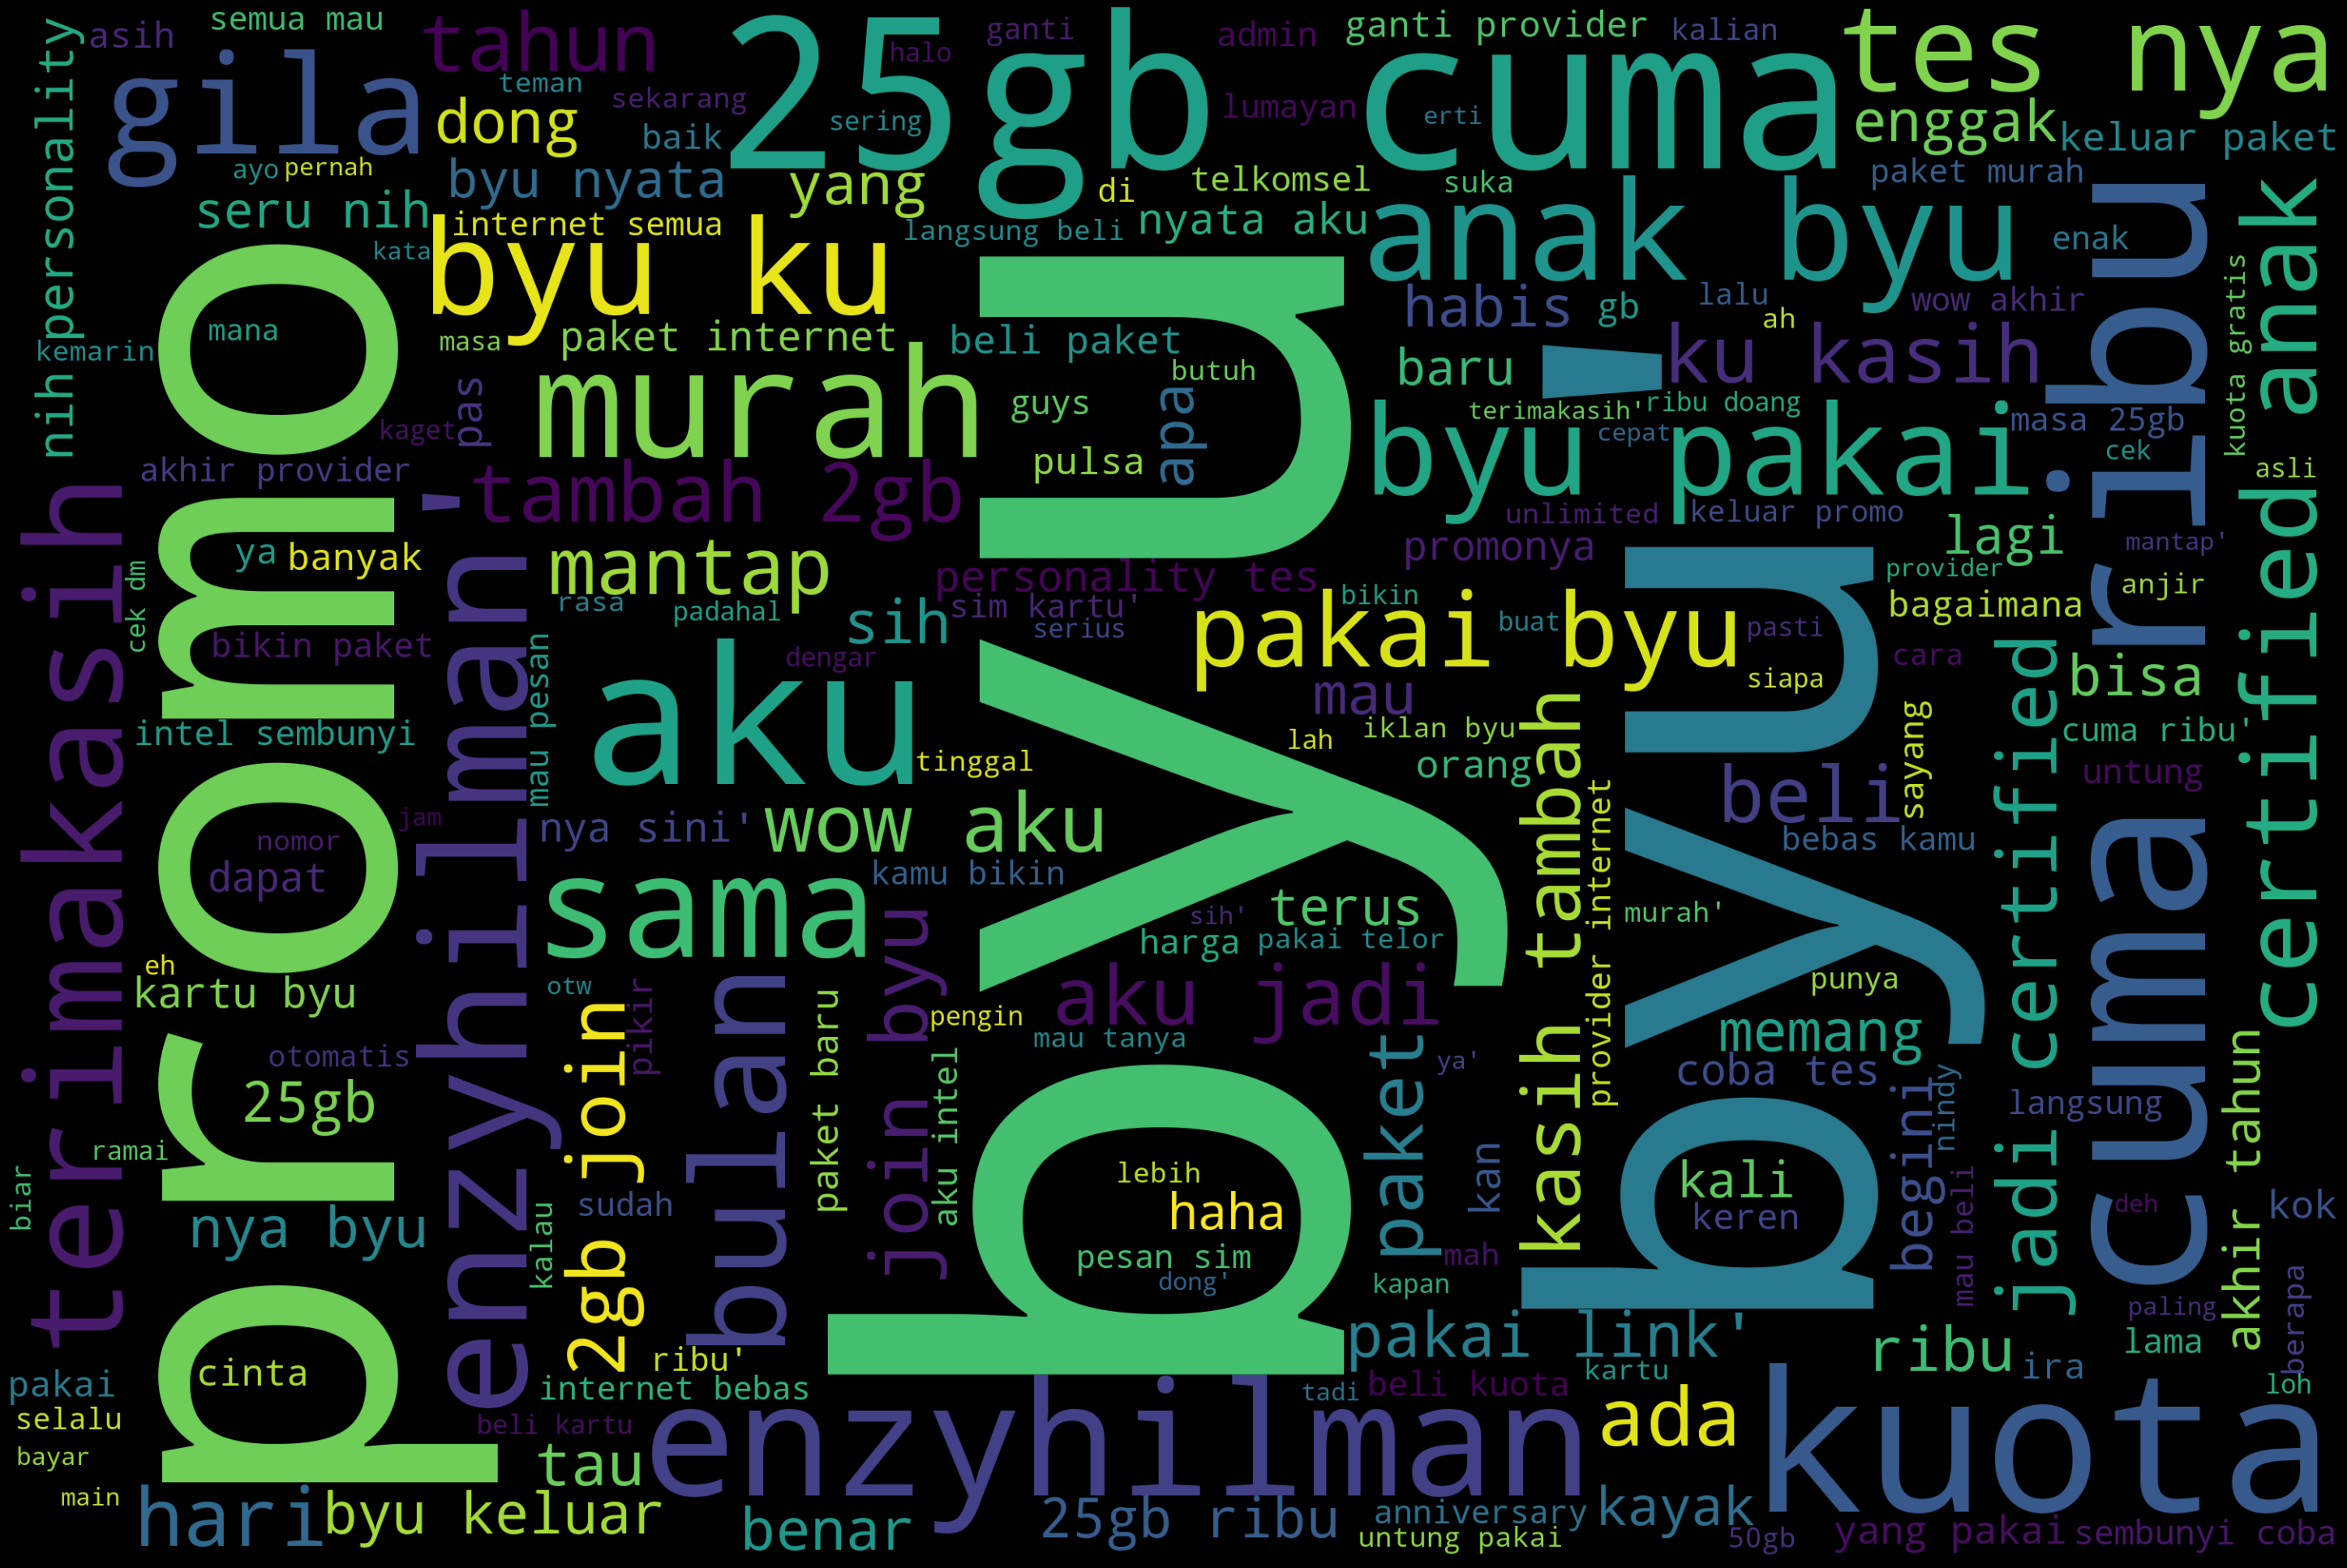

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = label_positif.text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [24]:
label_negatif = y[y['label'] == "negatif"]

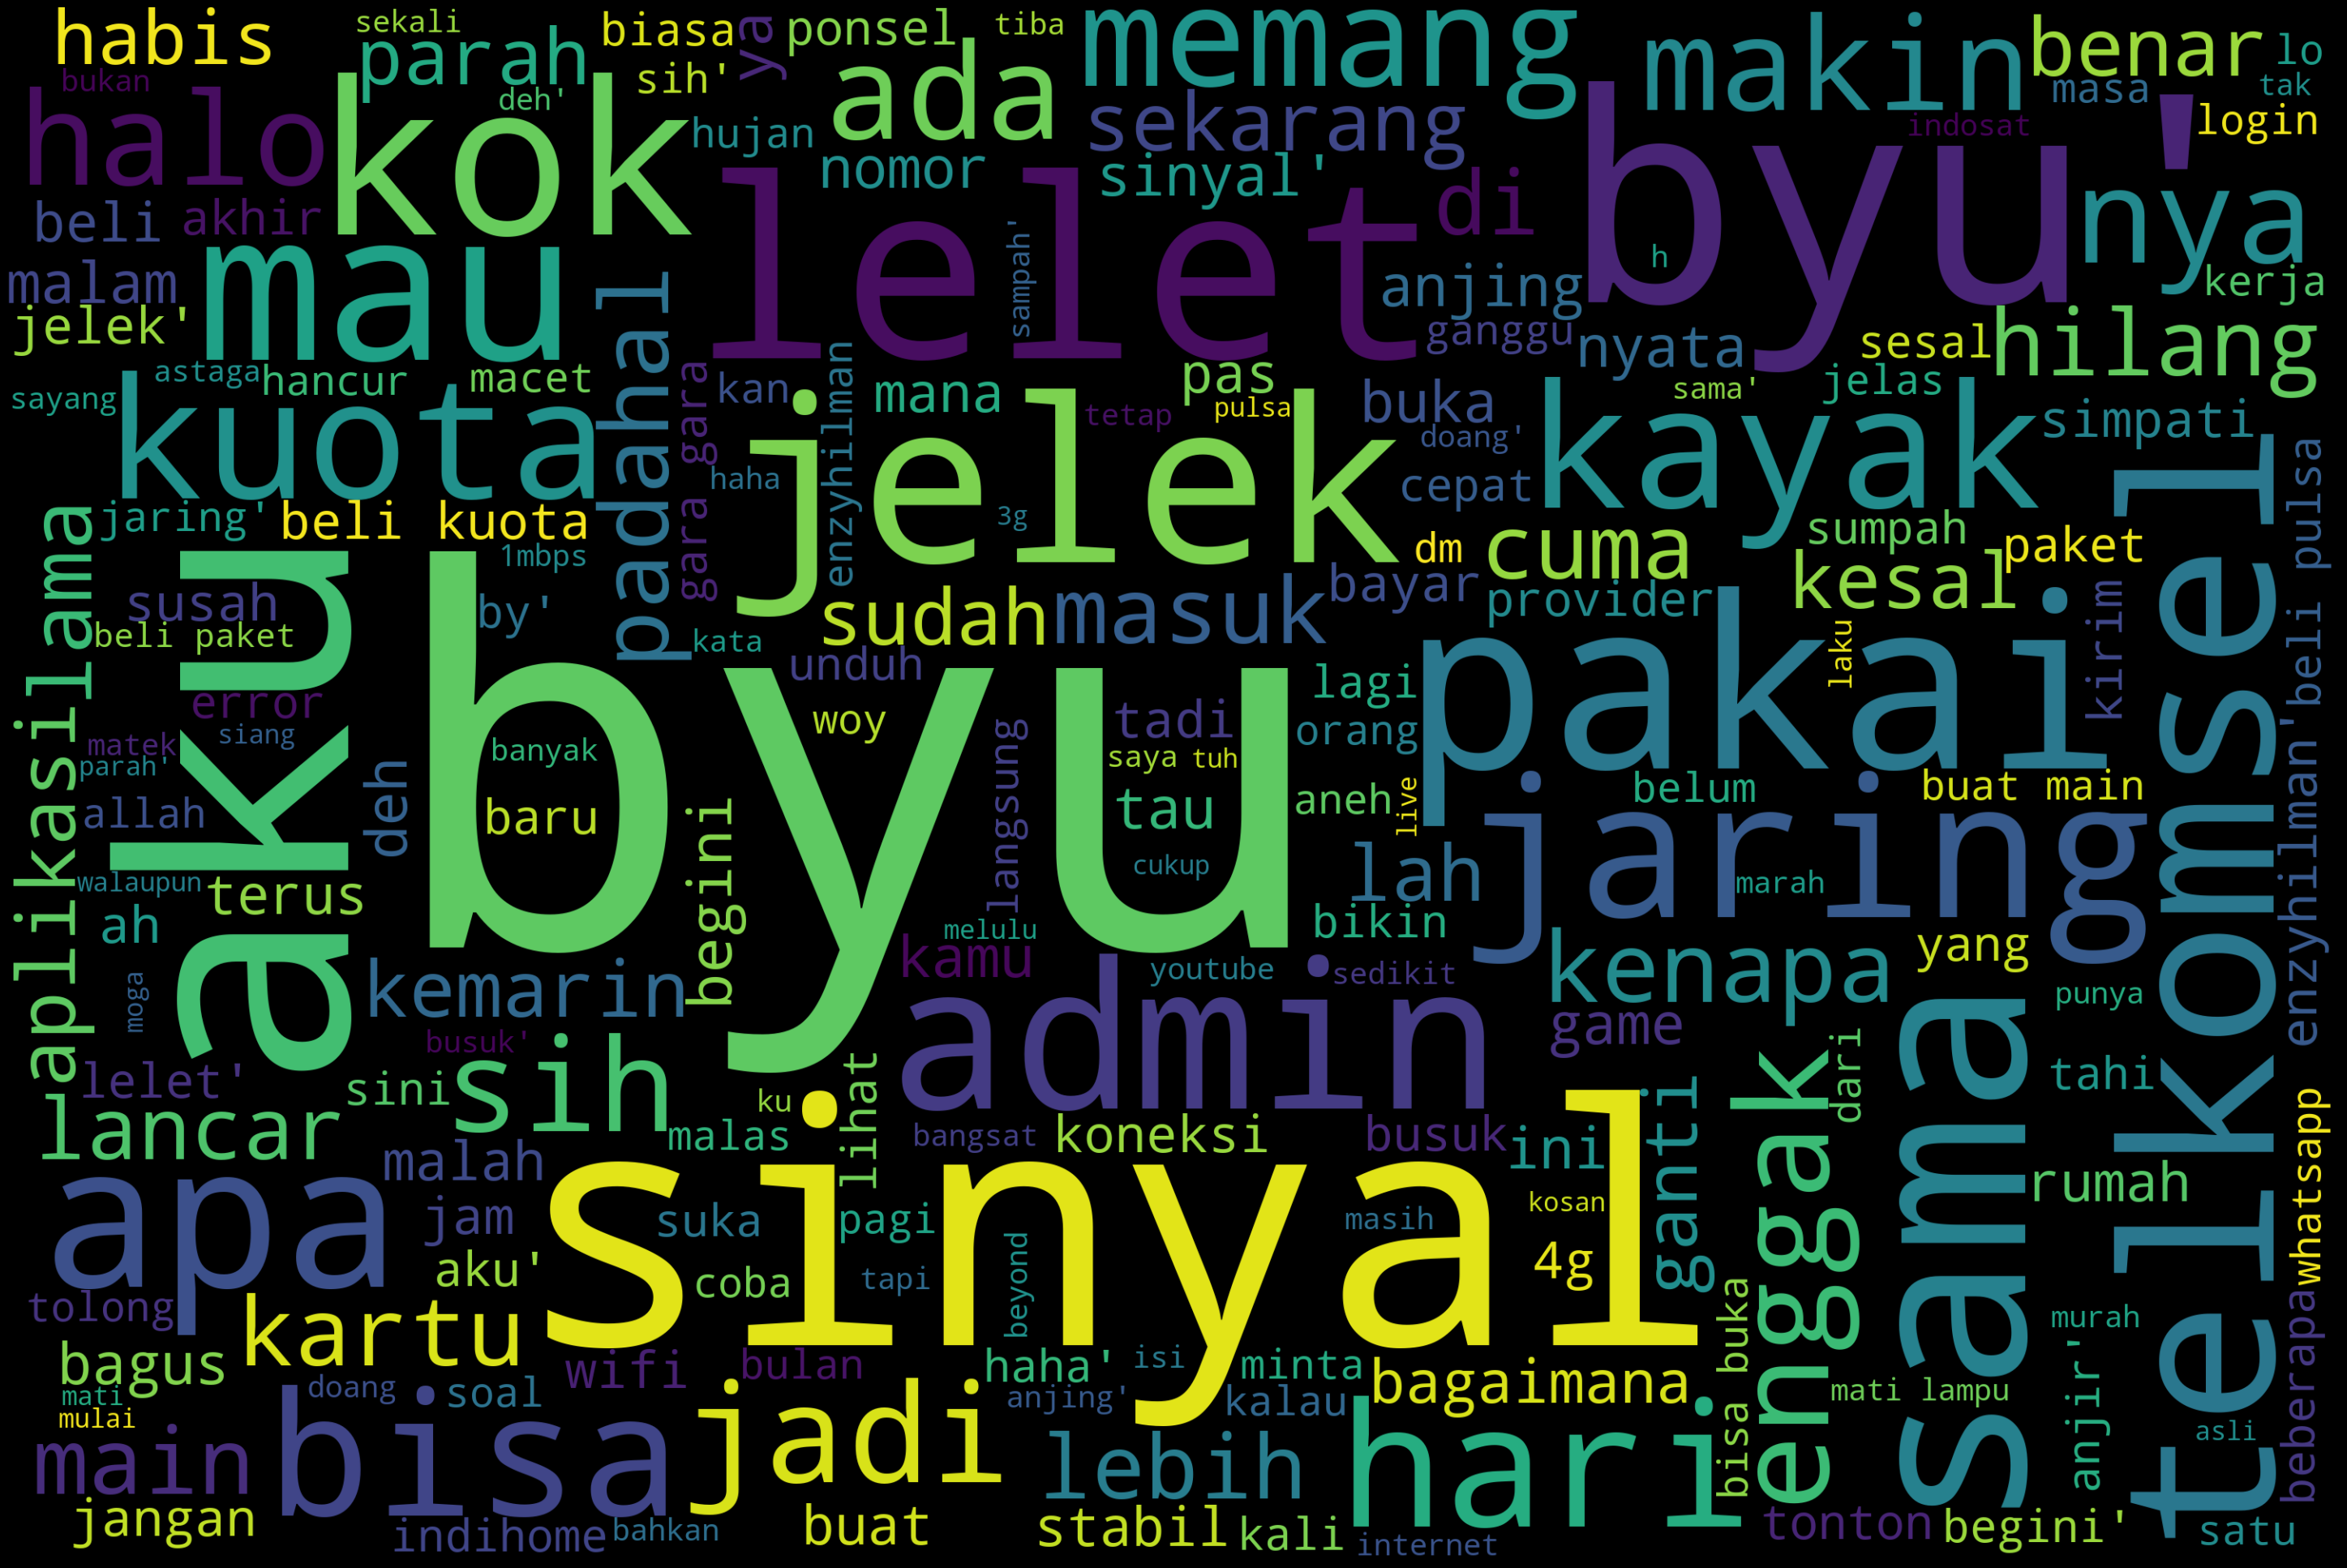

In [25]:
text = label_negatif.text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

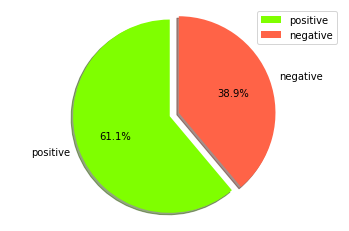

In [26]:
sizes = [l_hasil.count("positif"), l_hasil.count("negatif")]
labels = ['positive','negative']
colors = ['chartreuse', 'tomato']
explode = (0.1,0)

#patches, texts = plt.pie(sizes, colors=colors, startangle=-270)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(labels, loc="best")
plt.show()

In [27]:
positif=y.loc[y.label=="positif"]
negatif=y.loc[y.label=="negatif"]

In [28]:
positif

source                                               text  \
1     Twitter for Android  happy 1st anniversary byu sering sering trakti...   
2     Twitter for Android                               beli kuota byu kapan   
3     Twitter for Android  techi waktu masih 17 tahun loh dia pikir mungk...   
7     Twitter for Android           coba pakai byu by telkomsel moga cucookk   
8     Twitter for Android  beli kartu by telkomsel lewat link biar pakai ...   
...                   ...                                                ...   
1059  Twitter for Android                        kuota ajar byu apa bjiiirrr   
1064  Twitter for Android         baik done byu bayar paket malahnilang duit   
1072      Twitter Web App  terimakasih byu moga anniversary kuota makin g...   
1073  Twitter for Android                                      byu bagus sih   
1074  Twitter for Android  umum penting semua sayang nindy malam ada upgr...   

        label  
1     positif  
2     positif  
3     positif  
7     positif  
8     positif  
...       ...  
1059  positif  
1064  positif  
1072  positif  
1073  positif  
1074  positif  

[657 rows x 3 columns]

In [29]:
positiftest=y.loc[y.label=="positif", 'text']
negatiftest=y.loc[y.label=="negatif", 'text']

In [30]:
positiftest

1       happy 1st anniversary byu sering sering trakti...
2                                    beli kuota byu kapan
3       techi waktu masih 17 tahun loh dia pikir mungk...
7                coba pakai byu by telkomsel moga cucookk
8       beli kartu by telkomsel lewat link biar pakai ...
                              ...                        
1059                          kuota ajar byu apa bjiiirrr
1064           baik done byu bayar paket malahnilang duit
1072    terimakasih byu moga anniversary kuota makin g...
1073                                        byu bagus sih
1074    umum penting semua sayang nindy malam ada upgr...
Name: text, Length: 657, dtype: object

In [31]:
tekspositif='\n'.join(positiftest)
tekspositif

'happy 1st anniversary byu sering sering traktir kuota\nbeli kuota byu kapan\ntechi waktu masih 17 tahun loh dia pikir mungkin dunia lebih baik internet banyak jadi bully\ncoba pakai byu by telkomsel moga cucookk\nbeli kartu by telkomsel lewat link biar pakai kode referral by aku terus dapat bonus enak kan\nkuota mau habis tiba notifikasi begini terimakasih nindy byu\nwah 1 tahun kita byu\nbyu anak siapa\nbaik byu asih kuota gratis monthiversary huhuh terimakasih byu\nbeberapa relasi amp kolega jakarta pakai byu kita coba\nhalo temanteman bantu teman lulus yuk kriteria guna byu lama 3 bulan terus terus domisili\nmau raya anniversary nih byu\nkemarin kan aku beli kartu byu terus pilih 1mbps sama 2 danbl berapa begitu pokok aku beli 10kitu maksud bagaimana\naku pakai by tapi paket miskin alias 5gb 15 ribu\nguys mau tanya yang pakai kartu byu sampai rumah nya berapa hari\nsini adda pakai provider byu minta ulas dong bagus\nadmin byu paket 25mbps unlimited 140 ribu dibalikin kah\nbaru ecek

In [32]:
teksnegatif='\n'.join(negatiftest)
teksnegatif

'byu kerja sama cuma beberapa jam doang\nbyu anjggggg lagi t7s dodol malah lelet\ntonton beyond klive ada darah tinggi gara gara byu lelet njing amit amit\nindosat sinyal hari jelek bulan depan aku enggak jadi ganti byu\ntonton beyond live ada kesal anjing byu lelet tahi\nminta marah byu\nbyu hari lancar buat beberapa jam aku mau lihat nct\ngila byu sinyal jelek haha\nby tolong ayo jangan lemotty\nsinyal byu resah\nbyu lelet\nwalaupun aku stres lama kamar cenderung selalu layap aku coba bersemedi kost aku\naku mau beli kuota di sini by sinyal jelek yowes pasrah deh moga wifi kosan ngehe\ngon nya sayang this but im disgusting by pretending like jangan use link haram orang tonton yang live beyond me\nbyu mati lampu sinyal hilang\nah kesal akhir akhir byu suka jelek jaring jadi bisa tonton livenya\nmana sembah tahan puriz mana muncul laaku malas nk buka aib diekonon cukup aib aku orang\nasli by jelek sinyal\nbyu sih lelet naudzubillah\nbyu sinyal nya sampah\nlelet sih byu allah\n4g 3g byu

In [33]:
summarize(tekspositif, split=True)

['guys mau tanya yang pakai kartu byu sampai rumah nya berapa hari',
 'kuota byu habis mau beli kok paket banyak semua apa aku 50gb aku cuma butuh 1gb biar ponsel nyala',
 'malas isi paket 2 kali akhir pekan panjang di rumah wifi tetiba yang 3 bulan haha terimakasih nindy byu',
 'bisa mau beli paket byu terus bayar lalu shopee pay bagaimana sih cara yang tau',
 'guys sudah pakai byu bagaimana rasa mok minta dapat dong aku pengin ganti kesitu soal',
 'yang pakai byu mau tanya terang masa laku kuota doang apa sama masa laku kartu',
 'untng sopipay aku ada saldo lumayan nambhin beli kuota pas byu bisa bayar pakai shopepay',
 'sakit hati tadi habis beli kuota kartu byu pas cek nyata karti telkomsel ada promo',
 'kali yang pakai byu kode voucher maksud apa kode referal voucher kalau beli kuota',
 'aku bingung mau beli paket byu 50 ribu yang unlimited',
 'tau mau bagaimana ya iniastaghfirullah bulan akhir isi kuota habis tak buang sim kartu mu hey byu',
 'keren ada promo paket internet murah

In [34]:
summarize(teksnegatif, split=True)

['indosat sinyal hari jelek bulan depan aku enggak jadi ganti byu',
 'tonton beyond live ada kesal anjing byu lelet tahi',
 'byu hari lancar buat beberapa jam aku mau lihat nct',
 'ah kesal akhir akhir byu suka jelek jaring jadi bisa tonton livenya',
 'halo admin byu pakai kuota 10gb per hari kok bisa unduh',
 'bisa laku apa aku rumah sinyal byu jelek parah',
 'di aku doang apa kalian sih sinyal telkomsel masuk byu mulai lelet habis magrib',
 'kenapa sinyal byu jadi jelek bangeeettttt',
 'telkomsel sih allah sim kartu satu pakai byu telkomsel kan jelek huft',
 'et ada respon admin byu ini enggak login masa aktif habis entar malam mana beli',
 'byu buset lelet padahal sudah paket 2mbps anjir',
 'halo admin byu mau nanyain nomor sudah sen kok akhir kali update nomor gagal ter',
 'tau sudah kesal sama byu jadi reccommend buat main game',
 'byu memang benar bagus apa kalau iya mau ganti whatsapp sekali',
 'kapan aku main ml jaring nya lancar anjing byu',
 'kuota iya tambah banyak jaring ja

In [35]:
keywords(tekspositif).split('\n')

['anniversary byu sering',
 'enzyhilman',
 'bely',
 'kuota beli',
 'paket',
 'coba pakai',
 'promo',
 'ribu guys',
 'nya',
 'enggak',
 'aku terus dapat bonus enak kan',
 'bulan',
 'sih',
 'ada',
 'mbps sama',
 'tahun loh',
 'begini terimakasih nindy',
 'baru',
 'lah ira murah',
 'hari sini',
 'nyata',
 'bikin',
 'mau habis tiba',
 'kartu',
 'semua apa',
 'tanya yang',
 'wow',
 'cuma butuh',
 'haha',
 'orang',
 'kok',
 'benar bisa',
 'cinta',
 'provider',
 'lebih baik internet banyak jadi',
 'seru gila',
 'tau deh',
 'memang pas',
 'kali',
 'kamu',
 'akhir oke',
 'langsung',
 'masa',
 'sudah',
 'untung',
 'pulsa',
 'ganti',
 'lumayan',
 'lagi libur',
 'dong bagus admin',
 'mantap selamat natal',
 'lama',
 'bagaimana',
 'kayak ibu',
 'asih',
 'link biar',
 'cara',
 'nih',
 'anak siapa',
 'keren',
 'pikir',
 'berapa',
 'kapan',
 'nomor',
 'promonya',
 'mana',
 'doang',
 'teman',
 'lalu',
 'selalu',
 'sayang',
 'mah',
 'harga',
 'sekali',
 'buat',
 'cek',
 'otw',
 'anjir',
 'yuk',
 'keluar

In [36]:
keywords(teksnegatif).split('\n')

['byu kerja sama cuma beberapa jam doang',
 'indosat sinyal hari jelek',
 'apa',
 'telkomsel',
 'jaring',
 'pakai',
 'aku enggak jadi ganti',
 'kok',
 'bisa',
 'kayak',
 'mau lihat',
 'nya',
 'ada',
 'beli kuota',
 'malah lelet tonton',
 'padahal',
 'begini',
 'memang benar',
 'parah',
 'sekali halo admin',
 'sih',
 'nyata',
 'lah',
 'lancar buat',
 'kenapa',
 'terus',
 'mana',
 'hilang',
 'masuk',
 'habis',
 'sudah',
 'enzyhilman',
 'sekarang susah',
 'kamu',
 'bagaimana',
 'buka',
 'lama',
 'provider',
 'kesal anjing',
 'pas',
 'bikin',
 'ini',
 'game',
 'stabil main mobil',
 'haha',
 'rumah',
 'kartu satu',
 'makin malam bukan',
 'aplikasi',
 'tau',
 'kemarin isi paket',
 'busuk',
 'orang',
 'bagus',
 'koneksi pagi',
 'bayar',
 'jangan',
 'yang',
 'nomor baru',
 'lebih baik',
 'gara',
 'deh moga wifi',
 'whatsapp',
 'anjir',
 'unduh',
 'jelas',
 'ponsel',
 'woi',
 'woy',
 'tadi pulsa',
 'sumpah',
 'mbps',
 'tahi minta marah',
 'cepat kali',
 'bahkan indihome',
 'error',
 'belum',
 '

In [37]:
def get_word_frequency(tweets, count_once_per_tweet=False):
   
    count_all = Counter()
    for tweet in tweets:
        tokens = word_tokenize(tweet)
        terms_all = [term for term in tokens]
        if count_once_per_tweet:
            terms_all = set(terms_all) 
        count_all.update(terms_all) # update the counter
    return count_all

In [38]:
pos_tweet = get_word_frequency(positif['text'].values)
neg_tweet = get_word_frequency(negatif['text'].values)

In [39]:
pos_tweet

Counter({'happy': 6,
         '1st': 3,
         'anniversary': 15,
         'byu': 625,
         'sering': 9,
         'traktir': 1,
         'kuota': 90,
         'beli': 100,
         'kapan': 15,
         'techi': 1,
         'waktu': 1,
         'masih': 3,
         '17': 1,
         'tahun': 55,
         'loh': 10,
         'dia': 3,
         'pikir': 13,
         'mungkin': 2,
         'dunia': 3,
         'lebih': 10,
         'baik': 14,
         'internet': 36,
         'banyak': 19,
         'jadi': 74,
         'bully': 1,
         'coba': 40,
         'pakai': 160,
         'by': 50,
         'telkomsel': 16,
         'moga': 7,
         'cucookk': 1,
         'kartu': 48,
         'lewat': 2,
         'link': 34,
         'biar': 9,
         'kode': 4,
         'referral': 1,
         'aku': 173,
         'terus': 23,
         'dapat': 21,
         'bonus': 6,
         'enak': 13,
         'kan': 23,
         'mau': 70,
         'habis': 26,
         'tiba': 6,
         '

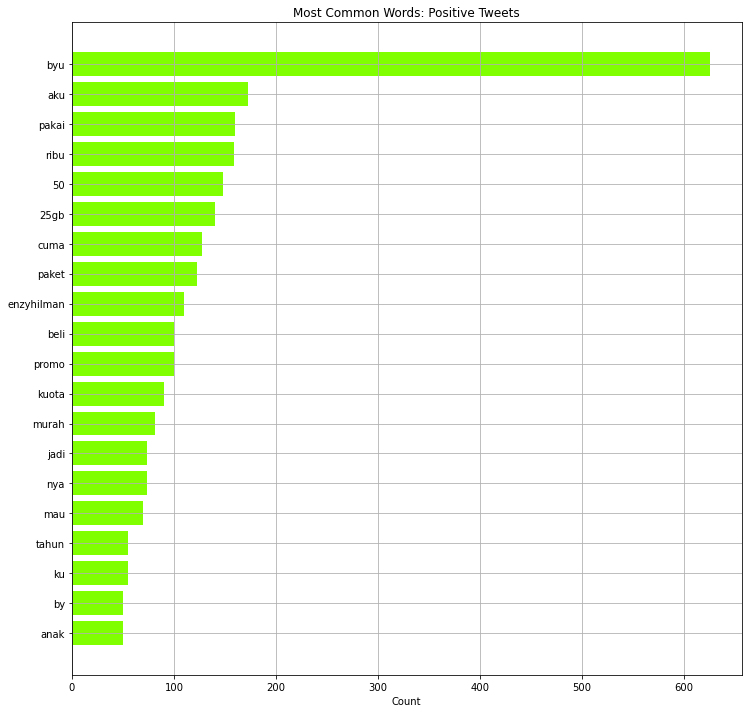

In [40]:
def plot_word_frequency(data, color='k', title='Twitter Word Count'):
    words, counts = zip(*data) 
    val = counts[::-1]   # sort the bars from longest to shortest
    words = words[::-1]
    pos = np.arange(len(data))+.5  # center the bars on the y axis
    
    plt.figure(figsize=(12,12))
    plt.barh(pos, val, align='center', color=color)
    plt.yticks(pos, words)
    plt.xlabel('Count')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_word_frequency(pos_tweet.most_common(20),'chartreuse','Most Common Words: Positive Tweets')
plot_word_frequency(neg_tweet.most_common(20),'tomato','Most Common Words: negative Tweets')

In [41]:
positifTest=y.loc[y.label=="positif"]
negatifTest=y.loc[y.label=="negatif"]

In [42]:
def get_source_label(source):
    jum = Counter(source).most_common()
    sour = []
    for sou, count in jum[:10]:
        sour.append(sou)
    return sour

def get_count_source(source,list_source):
    count_source = []
    list_source = pd.Series(list_source, dtype=object).tolist()
    for so in source:
        count = list_source.count(so)
        count_source.append(count)
     # update the counter
    return count_source

In [43]:
def show_count_sent(label,var1,var2,title):
    font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 18}
    plt.rc('font', **font)

    labels = label
    positif = get_count_source(labels,var1)
    negatif = get_count_source(labels,var2)

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig = plt.figure(figsize=(20, 10))
    ax = fig.subplots()
    rects1 = ax.bar(x - width/2, positif, width, label='Positive')
    rects2 = ax.bar(x + width/2, negatif, width, label='Negative')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

show_count_sent(get_source_label(data['source']),positifTest['source'],negatifTest['source'],'Naive Bayes Sentiment')

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio as imageio

In [45]:
def wordcloud (teks,title) :
    #background_mask = imageio.imread("speech-bubble.png")
    wc = WordCloud(background_color="black",
                   stopwords=STOPWORDS,
                   width=1800,
                   height=1400,)
                   #mask=background_mask)
    if not teks:
        teks = 'none'
    wordcloud = wc.generate(teks)
    return wordcloud

def display_wordcloud(wordcloud, title, n_components):
    print(title.title())
    plt.figure(figsize=(30, 8))
    j = np.ceil(n_components/4)
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 4, i).set_title("sentimen #" + str(t))
        plt.plot()
        plt.imshow(wordcloud[t], cmap=plt.cm.jet, interpolation="bilinear", aspect='auto'); plt.xticks(()); plt.yticks(())
        plt.axis("off")
    fig.suptitle(title)
    plt.show()
    
def get_klas_tweet_nb(source,sentimen):
    source_data = y.loc[y.label==sentimen]
    sent_source_data = source_data.loc[source_data.source==source,'text']
    teks_data = " ".join(str(v) for v in sent_source_data)
    return teks_data

Twitter For Android


Twitter For Iphone


Twitter Web App


Twitter For Mac


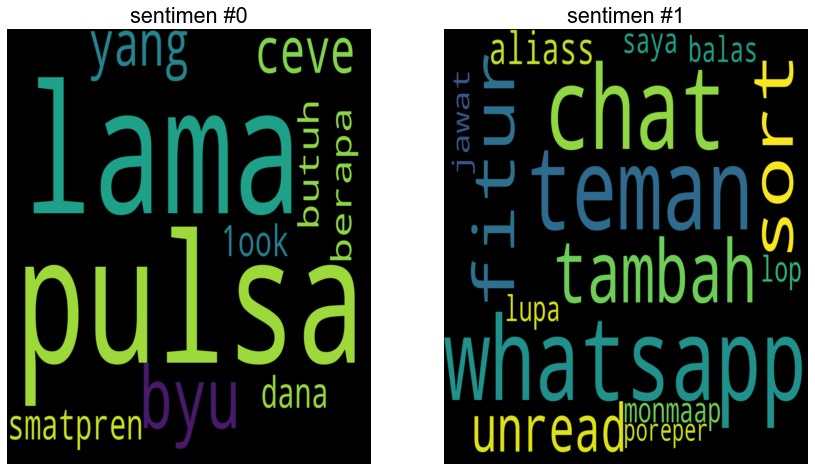

Twitter For Ipad


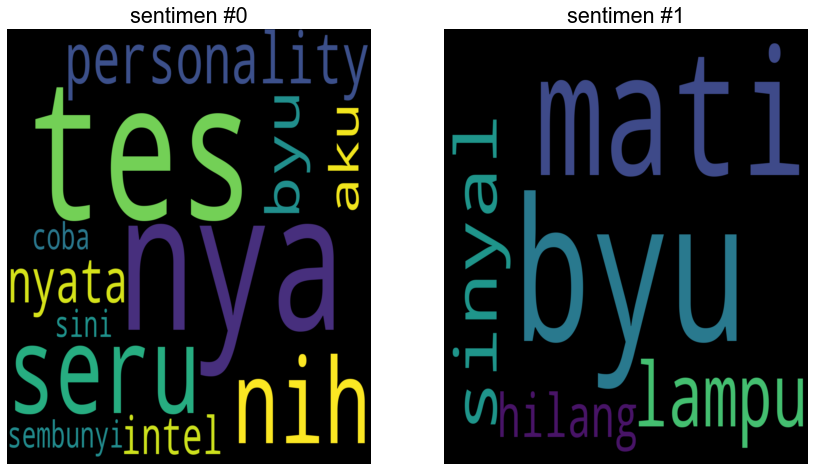

In [46]:
source = get_source_label(y['source'])

for i in source:
    wordcl = [wordcloud(get_klas_tweet_nb(i,"positif"),i),wordcloud(get_klas_tweet_nb(i,"negatif"),i)]
    display_wordcloud(wordcl, i, 2)